Loading: s11.dat

Subject file contains:
  • 40 trials
  • 40 signals (first 32 = EEG)
  • 8064 samples @ 128 Hz  (≈ 63 s)

Label vector   [Valence, Arousal, Dominance, Liking]:
  [8.42 1.82 6.01 7.69]

EEG sample preview (first 10 time points of channel 0):
  [ -0.41529 -11.38817 -12.3189   -3.19415  -4.81054   1.9751   11.85367
  -4.3339   -6.77476  21.8873 ]

Per-video mean ± std power of Ch-0 (quick sanity check):
  0.13184976622383035 ± 41.44266509322276


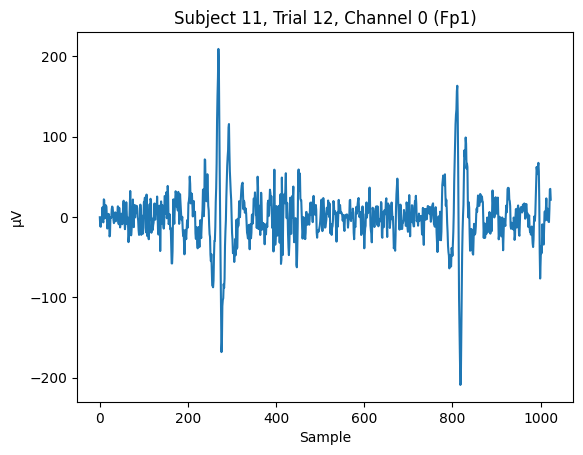

In [11]:
import pickle, numpy as np, pprint, os

# ------------------------------------------------------------------
# 1.  Pick one .dat file
# ------------------------------------------------------------------
dat_folder = 'data_preprocessed_python_full'        
fname = sorted(f for f in os.listdir(dat_folder) if f.endswith('.dat'))[10] # there are total 32 participants
print("Loading:", fname)

# ------------------------------------------------------------------
# 2.  Load with pickle (latin1 encoding!)
# ------------------------------------------------------------------
with open(os.path.join(dat_folder, fname), 'rb') as f:
    subj = pickle.load(f, encoding='latin1')

eeg_all   = subj['data']    # shape (40, 40, 8064)
labels_all = subj['labels']  # shape (40, 4)

print(f"\nSubject file contains:")
print(f"  • {eeg_all.shape[0]} trials")
print(f"  • {eeg_all.shape[1]} signals (first 32 = EEG)")
print(f"  • {eeg_all.shape[2]} samples @ 128 Hz  (≈ 63 s)")

# ------------------------------------------------------------------
# 3.  Inspect trial 0, channel map, label vector
# ------------------------------------------------------------------
trial_id = 12 # there are 40 trials for each participant
eeg = eeg_all[trial_id, :32]          # 32×8064  EEG only
label_vec = labels_all[trial_id]      # [V, A, D, L]

print("\nLabel vector   [Valence, Arousal, Dominance, Liking]:")
print(" ", label_vec)

print("\nEEG sample preview (first 10 time points of channel 0):")
print(" ", np.round(eeg[0, :10],    5))

print("\nPer-video mean ± std power of Ch-0 (quick sanity check):")
print(" ", np.mean(eeg[0]), "±", np.std(eeg[0]))

# ------------------------------------------------------------------
# 4.  visualise one channel
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.plot(eeg[0, :1024])           # first 8 s @ 128 Hz
plt.title(f'Subject {fname[1:3]}, Trial {trial_id}, Channel 0 (Fp1)')
plt.xlabel('Sample');  plt.ylabel('µV')
plt.show()


# Version 1
### 8 equal sized sub-reservoirs as a starter

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from numpy.linalg import eigvals

# ---------------------------------------------------------------------
# Utility helpers
# ---------------------------------------------------------------------
def scale_spectral_radius(W, desired_radius=0.95):
    """Affine-scale square matrix W so that its spectral radius equals desired_radius."""
    eigs = eigvals(W)
    current_radius = np.max(np.abs(eigs))
    if current_radius == 0:
        raise ValueError("Spectral radius of W is zero.")
    return W * (desired_radius / current_radius)

def augment_state_with_squares(x):
    """[x, x^2, 1]   (same convention as in CycleReservoir3D)."""
    return np.concatenate([x, x**2, [1.0]])

# ---------------------------------------------------------------------
# HH-LR class
# ---------------------------------------------------------------------
class HHLobeReservoir:
    """
    Hemispherically-Hierarchical Lobe Reservoir (HH-LR).

    Topology:
      * 8 anatomical modules  —  L/R × {F, P, T, O}
      * Intra-module: Watts–Strogatz small-world graphs (ring+rewire)
      * Intra-hemisphere inter-lobe: distance-modulated shortcuts
      * Inter-hemisphere (callosal): sparse homotopic bridges
    """

    # --- anatomical bookkeeping -------------------------------------------------
    _LOBES   = ['F', 'P', 'T', 'O']
    _HEMIS   = ['L', 'R']
    # rough 2-D centroids (arbitrary units) for distance computation
    _CENTROIDS = {
        ('L', 'F'): (-1.0,  1.0),
        ('L', 'P'): (-1.0,  0.0),
        ('L', 'T'): (-1.0, -1.0),
        ('L', 'O'): (-1.0, -2.0),
        ('R', 'F'): ( 1.0,  1.0),
        ('R', 'P'): ( 1.0,  0.0),
        ('R', 'T'): ( 1.0, -1.0),
        ('R', 'O'): ( 1.0, -2.0),
    }

    # ------------------------------------------------------------------
    def __init__(self,
                 reservoir_size=800,
                 input_dim=128,
                 spectral_radius=0.9,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 # small-world / shortcut hyper-parameters
                 k_ring=8,
                 p_rewire_frontal=0.30,
                 p_rewire_other=0.10,
                 P_lat=0.04,
                 sigma=5.0,
                 P_call=0.01,
                 seed=42):
        """
        Parameters
        ----------
        reservoir_size   : total neuron count (split equally across the 8 modules if not divisible)
        input_dim        : dimensionality of input vector u_t  (128 for EEG band-power features)
        leaking_rate     : α in leaky-integrator update
        """
        self.N     = reservoir_size
        self.D_in  = input_dim
        self.rho   = spectral_radius
        self.in_scale   = input_scale
        self.alpha = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed  = seed

        # ------------------------------------------------------------------
        # 1) allocate neurons to the 8 modules as evenly as possible
        # ------------------------------------------------------------------
        base = self.N // 8
        counts = [base] * 8
        for i in range(self.N - base*8):
            counts[i] += 1
        self._module_slices = {}
        idx0 = 0
        for h in self._HEMIS:
            for l in self._LOBES:
                n = counts[len(self._module_slices)]
                self._module_slices[(h, l)] = slice(idx0, idx0 + n)
                idx0 += n

        # ------------------------------------------------------------------
        # 2) build adjacency matrix W according to HH-LR rules
        # ------------------------------------------------------------------
        rng = np.random.default_rng(self.seed)
        W = np.zeros((self.N, self.N), dtype=float)

        # 2.1 intra-module small-world wiring
        for (h, l), sl in self._module_slices.items():
            n_mod = sl.stop - sl.start
            k = min(k_ring, n_mod-1)  # guard tiny modules
            p_rewire = p_rewire_frontal if l == 'F' else p_rewire_other
            # ring lattice
            for i_local in range(n_mod):
                for m in range(1, k+1):
                    j_local = (i_local + m) % n_mod
                    i_glob = sl.start + i_local
                    j_glob = sl.start + j_local
                    W[i_glob, j_glob] = rng.standard_normal()
                    W[j_glob, i_glob] = rng.standard_normal()
            # rewire each existing edge with prob p_rewire
            for i_local in range(n_mod):
                for m in range(1, k+1):
                    if rng.random() < p_rewire:
                        # pick a random new target in same module (avoid self-loop)
                        j_local_new = rng.integers(0, n_mod-1)
                        if j_local_new >= i_local:
                            j_local_new += 1
                        i_glob = sl.start + i_local
                        j_glob_new = sl.start + j_local_new
                        # overwrite previous weight (both directions)
                        w_new = rng.standard_normal()
                        W[i_glob, j_glob_new] = w_new
                        W[j_glob_new, i_glob] = rng.standard_normal()

        # 2.2 intra-hemisphere inter-lobe shortcuts (distance-weighted)
        for h in self._HEMIS:
            for l1 in self._LOBES:
                for l2 in self._LOBES:
                    if l1 == l2:
                        continue
                    sl1 = self._module_slices[(h, l1)]
                    sl2 = self._module_slices[(h, l2)]
                    c1 = np.array(self._CENTROIDS[(h, l1)])
                    c2 = np.array(self._CENTROIDS[(h, l2)])
                    dist = np.linalg.norm(c1 - c2)
                    p_edge = P_lat * np.exp(-dist / sigma)
                    for i in range(sl1.start, sl1.stop):
                        mask = rng.random(sl2.stop - sl2.start) < p_edge
                        js = np.nonzero(mask)[0] + sl2.start
                        if js.size:
                            W[i, js] = rng.standard_normal(size=js.size)
                            W[js, i] = rng.standard_normal(size=js.size)

        # 2.3 inter-hemisphere callosal bridges (homotopic)
        for l in self._LOBES:
            sl_L = self._module_slices[('L', l)]
            sl_R = self._module_slices[('R', l)]
            for i in range(sl_L.start, sl_L.stop):
                mask = rng.random(sl_R.stop - sl_R.start) < P_call
                js = np.nonzero(mask)[0] + sl_R.start
                if js.size:
                    W[i, js] = rng.standard_normal(size=js.size)
                    W[js, i] = rng.standard_normal(size=js.size)

        # 2.4 spectral scaling
        W = scale_spectral_radius(W, self.rho)
        self.W = W

        # ------------------------------------------------------------------
        # 3) random input weights
        # ------------------------------------------------------------------
        rng = np.random.default_rng(self.seed + 1)
        self.W_in = (rng.random((self.N, self.D_in)) - 0.5) * 2.0 * self.in_scale

        # readout and state
        self.W_out = None
        self.x = np.zeros(self.N)

    # ------------------------------------------------------------------
    # ESN core methods (same signatures as CycleReservoir3D)
    # ------------------------------------------------------------------
    def reset_state(self):
        self.x = np.zeros(self.N)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Parameters
        ----------
        inputs  : iterable / array of shape (T, input_dim)
        discard : number of initial time-steps to omit from training
        """
        self.reset_state()
        states = []
        for u in inputs:
            self._update(u)
            states.append(self.x.copy())
        return np.array(states[discard:]), np.array(states[:discard])

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Ridge regression read-out; identical augmentation as baseline.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_aug = np.vstack([augment_state_with_squares(s) for s in states_use])

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_sequence(self, inputs):
        """
        Feed-forward prediction (no teacher forcing).  Suitable for classification:
        returns raw linear outputs; apply threshold/sigmoid externally.
        """
        preds = []
        self.reset_state()
        for u in inputs:
            self._update(u)
            preds.append(self.W_out @ augment_state_with_squares(self.x)) # quadratic lift-off
            #preds.append(self.W_out @ self.x)
        return np.array(preds)
    
    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            out = self.W_out @ augment_state_with_squares(self.x)
            preds.append(out)
            current_in = out
        return np.array(preds)

# Version 2
### 4 : 3 : 2 : 1 frontal → occipital ratio in each hemisphere

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from numpy.linalg import eigvals

# ---------------------------------------------------------------------
# Utility helpers
# ---------------------------------------------------------------------
def scale_spectral_radius(W, desired_radius=0.95):
    """Affine-scale W so that its spectral radius equals desired_radius."""
    eigs = eigvals(W)
    radius = np.max(np.abs(eigs))
    if radius == 0:
        raise ValueError("Spectral radius of W is zero.")
    return W * (desired_radius / radius)


def augment_state_with_squares(x):
    """Return [x, x², 1] (same convention as in CycleReservoir3D)."""
    return np.concatenate([x, x**2, [1.0]])


# ---------------------------------------------------------------------
# Hemispherically–Hierarchical Lobe Reservoir
# ---------------------------------------------------------------------
class HHLobeReservoir:
    """
    Hemispherically-Hierarchical Lobe Reservoir (HH-LR)

    • 8 anatomical modules  —  L/R × {F, P, T, O}
    • Intra-module: Watts–Strogatz small-world graphs (ring + rewire)
    • Intra-hemisphere shortcuts: distance-modulated (exp decay)
    • Inter-hemisphere bridges: sparse homotopic callosal links
    • Lobe cardinalities follow MRI volume ratio 4 : 3 : 2 : 1
    """

    # bookkeeping ------------------------------------------------------
    _LOBES  = ['F', 'P', 'T', 'O']
    _HEMIS  = ['L', 'R']
    _CENTROIDS = {                             # rough 2-D montage coords
        ('L', 'F'): (-1.0,  1.0), ('L', 'P'): (-1.0,  0.0),
        ('L', 'T'): (-1.0, -1.0), ('L', 'O'): (-1.0, -2.0),
        ('R', 'F'): ( 1.0,  1.0), ('R', 'P'): ( 1.0,  0.0),
        ('R', 'T'): ( 1.0, -1.0), ('R', 'O'): ( 1.0, -2.0),
    }

    # ------------------------------------------------------------------
    def __init__(self,
                 reservoir_size=800,
                 input_dim=32,
                 spectral_radius=0.9,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 # small-world / shortcut hyper-parameters
                 k_ring=8,
                 p_rewire_frontal=0.30,
                 p_rewire_other=0.10,
                 P_lat=0.04,
                 sigma=5.0,
                 P_call=0.01,
                 seed=42):
        """
        reservoir_size : total number of neurons (N)
        input_dim      : dimension of u_t  (128 for EEG band-power features)
        leaking_rate   : α in leaky-integrator update
        """
        self.N          = reservoir_size
        self.D_in       = input_dim
        self.rho        = spectral_radius
        self.in_scale   = input_scale
        self.alpha      = leaking_rate
        self.ridge_alpha= ridge_alpha
        self.seed       = seed

        # --------------------------------------------------------------
        # 1) allocate neurons:  per-hemisphere 4 : 3 : 2 : 1 (F:P:T:O)
        # --------------------------------------------------------------
        ratio = {'F': 4, 'P': 3, 'T': 2, 'O': 1}
        total_w = sum(ratio.values())          # = 10
        half_N  = self.N // 2                  # neurons per hemisphere

        counts_per_hemi = {
            l: int(half_N * ratio[l] / total_w) for l in self._LOBES
        }

        # distribute rounding residuals (largest fractional remainder first)
        residual = half_N - sum(counts_per_hemi.values())
        if residual > 0:
            remainders = sorted(
                self._LOBES,
                key=lambda l: (half_N * ratio[l] / total_w) - counts_per_hemi[l],
                reverse=True
            )
            for l in remainders[:residual]:
                counts_per_hemi[l] += 1

        # build slice table
        self._module_slices = {}
        idx0 = 0
        for h in self._HEMIS:          # L then R
            for l in self._LOBES:      # F, P, T, O
                n = counts_per_hemi[l]
                self._module_slices[(h, l)] = slice(idx0, idx0 + n)
                idx0 += n
        assert idx0 == self.N, "Slice allocation error"

        # --------------------------------------------------------------
        # 2) construct adjacency matrix W according to HH-LR rules
        # --------------------------------------------------------------
        rng = np.random.default_rng(self.seed)
        W = np.zeros((self.N, self.N), dtype=float)

        # 2.1 intra-module small-world wiring
        for (h, l), sl in self._module_slices.items():
            n_mod = sl.stop - sl.start
            k = min(k_ring, n_mod - 1)
            p_rewire = p_rewire_frontal if l == 'F' else p_rewire_other

            # ring lattice
            for i_local in range(n_mod):
                for m in range(1, k + 1):
                    j_local = (i_local + m) % n_mod
                    i_glob  = sl.start + i_local
                    j_glob  = sl.start + j_local
                    W[i_glob, j_glob] = rng.standard_normal()
                    W[j_glob, i_glob] = rng.standard_normal()

            # random rewiring
            for i_local in range(n_mod):
                for m in range(1, k + 1):
                    if rng.random() < p_rewire:
                        j_local_new = rng.integers(0, n_mod - 1)
                        if j_local_new >= i_local:
                            j_local_new += 1
                        i_glob = sl.start + i_local
                        j_glob_new = sl.start + j_local_new
                        w_new = rng.standard_normal()
                        W[i_glob, j_glob_new] = w_new
                        W[j_glob_new, i_glob] = rng.standard_normal()

        # 2.2 intra-hemisphere distance-weighted shortcuts
        for h in self._HEMIS:
            for l1 in self._LOBES:
                for l2 in self._LOBES:
                    if l1 == l2:
                        continue
                    sl1 = self._module_slices[(h, l1)]
                    sl2 = self._module_slices[(h, l2)]
                    d = np.linalg.norm(
                        np.array(self._CENTROIDS[(h, l1)]) -
                        np.array(self._CENTROIDS[(h, l2)])
                    )
                    p_edge = P_lat * np.exp(-d / sigma)
                    for i in range(sl1.start, sl1.stop):
                        mask = rng.random(sl2.stop - sl2.start) < p_edge
                        js = np.nonzero(mask)[0] + sl2.start
                        if js.size:
                            W[i, js] = rng.standard_normal(size=js.size)
                            W[js, i] = rng.standard_normal(size=js.size)

        # 2.3 inter-hemisphere homotopic callosal links
        for l in self._LOBES:
            sl_L = self._module_slices[('L', l)]
            sl_R = self._module_slices[('R', l)]
            for i in range(sl_L.start, sl_L.stop):
                mask = rng.random(sl_R.stop - sl_R.start) < P_call
                js = np.nonzero(mask)[0] + sl_R.start
                if js.size:
                    W[i, js] = rng.standard_normal(size=js.size)
                    W[js, i] = rng.standard_normal(size=js.size)

        # 2.4 spectral scaling to enforce ESP
        self.W = scale_spectral_radius(W, self.rho)

        # --------------------------------------------------------------
        # 3) random input weights
        # --------------------------------------------------------------
        rng = np.random.default_rng(self.seed + 1)
        self.W_in = (rng.random((self.N, self.D_in)) - 0.5) * 2.0 * self.in_scale

        # initialize state & read-out
        self.x = np.zeros(self.N)
        self.W_out = None

    # ------------------------------------------------------------------
    # ESN core methods --------------------------------------------------
    # ------------------------------------------------------------------
    def reset_state(self):
        self.x.fill(0.0)

    def _update(self, u):
        pre = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for u in inputs:
            self._update(u)
            states.append(self.x.copy())
        return np.array(states[discard:]), np.array(states[:discard])

    # ------------------------------------------------------------------
    # read-out ----------------------------------------------------------
    # ------------------------------------------------------------------
    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard)
        targets_use = train_target[discard:]
        X_aug = np.vstack([augment_state_with_squares(s) for s in states_use])

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_sequence(self, inputs):
        preds = []
        self.reset_state()
        for u in inputs:
            self._update(u)
            preds.append(self.W_out @ augment_state_with_squares(self.x))
        return np.array(preds)
    
    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            out = self.W_out @ augment_state_with_squares(self.x)
            preds.append(out)
            current_in = out
        return np.array(preds)


# Version 3 
### anatomically aligned input weights

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from numpy.linalg import eigvals

# ---------------------------------------------------------------------
# helpers
# ---------------------------------------------------------------------
def scale_spectral_radius(W, desired_radius=0.95):
    """Affine-scale W so its spectral radius equals desired_radius."""
    r = np.max(np.abs(eigvals(W)))
    if r == 0:
        raise ValueError("Spectral radius is zero.")
    return W * (desired_radius / r)


def augment_state_with_squares(x):
    """Return [x, x², 1] (for polynomial read-out)."""
    return np.concatenate([x, x ** 2, [1.0]])


# ---------------------------------------------------------------------
# Hemispherically–Hierarchical Lobe Reservoir
# ---------------------------------------------------------------------
class HHLobeReservoir:
    """
    Neuro-anatomically stratified ESN (HH-LR).

    • 8 modules  -  (L/R) x {F, P, T, O}, cardinalities 4 : 3 : 2 : 1
    • Watts-Strogatz micro-circuits per module
    • Distance-decayed intra-hemisphere shortcuts
    • Sparse homotopic callosal bridges
    • Optional channel-to-module input masking
    """

    # bookkeeping ------------------------------------------------------
    _LOBES = ['F', 'P', 'T', 'O']
    _HEMIS = ['L', 'R']
    _CENTROIDS = {  # 2-D scalp coords for shortcut probability
        ('L', 'F'): (-1.0,  1.0), ('L', 'P'): (-1.0,  0.0),
        ('L', 'T'): (-1.0, -1.0), ('L', 'O'): (-1.0, -2.0),
        ('R', 'F'): ( 1.0,  1.0), ('R', 'P'): ( 1.0,  0.0),
        ('R', 'T'): ( 1.0, -1.0), ('R', 'O'): ( 1.0, -2.0),
    }

    # channel index → (hemi, lobe) mapping for DEAP-32 montage ----------
    _CHANNEL_TO_MODULE = {
        0: ('L', 'F'),  1: ('L', 'F'),  2: ('L', 'F'),  3: ('L', 'F'),
        4: ('L', 'F'),  5: ('L', 'F'),  6: ('L', 'T'),  7: ('L', 'T'),
        8: ('L', 'T'),  9: ('L', 'P'), 10: ('L', 'P'), 11: ('L', 'P'),
       12: ('L', 'P'), 13: ('L', 'O'), 14: ('L', 'O'), 15: ('L', 'P'),
       16: ('R', 'F'), 17: ('R', 'F'), 18: ('R', 'F'), 19: ('R', 'F'),
       20: ('R', 'F'), 21: ('R', 'F'), 22: ('R', 'T'), 23: ('R', 'T'),
       24: ('R', 'T'), 25: ('R', 'P'), 26: ('R', 'P'), 27: ('R', 'P'),
       28: ('R', 'P'), 29: ('R', 'O'), 30: ('R', 'O'), 31: ('R', 'P')
    }
    # each EEG channel contributes 4 power-band features ⇒ col = ch*4 … ch*4+3

    # ------------------------------------------------------------------
    def __init__(self,
                 reservoir_size=800,
                 input_dim=32,
                 spectral_radius=0.9,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 k_ring=8,
                 p_rewire_frontal=0.30,
                 p_rewire_other=0.10,
                 P_lat=0.04,
                 sigma=5.0,
                 P_call=0.01,
                 structured_input=False, # this is meant for 128-D band-power features, not for raw EEG
                 cross_ratio=0.05,
                 seed=42):
        self.N = reservoir_size
        self.D_in = input_dim
        self.rho = spectral_radius
        self.in_scale = input_scale
        self.alpha = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed
        rng = np.random.default_rng(seed)

        # --------------------------------------------------------------
        # 1) module sizes – 4 : 3 : 2 : 1 per hemisphere
        # --------------------------------------------------------------
        ratio = dict(F=4, P=3, T=2, O=1)
        total_w, half_N = sum(ratio.values()), self.N // 2
        counts = {l: int(half_N * ratio[l] / total_w) for l in self._LOBES}
        # rounding residual
        resid = half_N - sum(counts.values())
        if resid:
            order = sorted(self._LOBES,
                           key=lambda l: (half_N * ratio[l] / total_w) - counts[l],
                           reverse=True)
            for l in order[:resid]:
                counts[l] += 1

        self._module_slices, idx0 = {}, 0
        for h in self._HEMIS:
            for l in self._LOBES:
                n = counts[l]
                self._module_slices[(h, l)] = slice(idx0, idx0 + n)
                idx0 += n
        assert idx0 == self.N

        # --------------------------------------------------------------
        # 2) recurrent matrix W  (rules §2.1–2.3)
        # --------------------------------------------------------------
        W = np.zeros((self.N, self.N))
        # 2.1 small-world within each module
        for (h, l), sl in self._module_slices.items():
            n_mod = sl.stop - sl.start
            k = min(k_ring, n_mod - 1)
            p_rw = p_rewire_frontal if l == 'F' else p_rewire_other
            for i_local in range(n_mod):
                i_g = sl.start + i_local
                for m in range(1, k + 1):
                    j_g = sl.start + (i_local + m) % n_mod
                    W[i_g, j_g] = rng.standard_normal()
                    W[j_g, i_g] = rng.standard_normal()
                    if rng.random() < p_rw:
                        j_new = sl.start + rng.integers(0, n_mod - 1)
                        if j_new >= i_g:
                            j_new += 1
                        W[i_g, j_new] = rng.standard_normal()
                        W[j_new, i_g] = rng.standard_normal()

        # 2.2 distance-weighted shortcuts
        for h in self._HEMIS:
            for l1 in self._LOBES:
                for l2 in self._LOBES:
                    if l1 == l2:
                        continue
                    sl1, sl2 = self._module_slices[(h, l1)], self._module_slices[(h, l2)]
                    dist = np.linalg.norm(np.array(self._CENTROIDS[(h, l1)]) -
                                          np.array(self._CENTROIDS[(h, l2)]))
                    p_edge = P_lat * np.exp(-dist / sigma)
                    for i in range(sl1.start, sl1.stop):
                        mask = rng.random(sl2.stop - sl2.start) < p_edge
                        js = np.nonzero(mask)[0] + sl2.start
                        if js.size:
                            W[i, js] = rng.standard_normal(js.size)
                            W[js, i] = rng.standard_normal(js.size)

        # 2.3 callosal bridges
        for l in self._LOBES:
            sL, sR = self._module_slices[('L', l)], self._module_slices[('R', l)]
            for i in range(sL.start, sL.stop):
                mask = rng.random(sR.stop - sR.start) < P_call
                js = np.nonzero(mask)[0] + sR.start
                if js.size:
                    W[i, js] = rng.standard_normal(js.size)
                    W[js, i] = rng.standard_normal(js.size)

        self.W = scale_spectral_radius(W, self.rho)

        # --------------------------------------------------------------
        # 3) input weights  (dense or structured)
        # --------------------------------------------------------------
        if structured_input:
            self.W_in = self._build_structured_Win(cross_ratio)
        else:
            rng = np.random.default_rng(seed + 1)
            self.W_in = (rng.random((self.N, self.D_in)) - 0.5) * 2 * self.in_scale

        # state & read-out
        self.x = np.zeros(self.N)
        self.W_out = None

    # ------------------------------------------------------------------
    # structured input builder
    # ------------------------------------------------------------------
    def _build_structured_Win(self, cross_ratio):
        rng = np.random.default_rng(self.seed + 1)
        W_in = np.zeros((self.N, self.D_in))
        for (h, l), sl in self._module_slices.items():
            # columns for this module
            cols = [ch * 4 + b
                    for ch, mod in self._CHANNEL_TO_MODULE.items()
                    if mod == (h, l) for b in range(4)]
            if cols:
                W_in[sl, cols] = (rng.random((sl.stop - sl.start, len(cols))) - 0.5) \
                                  * 2 * self.in_scale
            # sprinkle cross-module connections
            k = int(cross_ratio * self.D_in)
            if k > 0:
                extra = rng.choice(self.D_in, k, replace=False)
                W_in[sl, extra] += ((rng.random((sl.stop - sl.start, k)) - 0.5)
                                    * 2 * self.in_scale / 5.0)
        return W_in

    # ------------------------------------------------------------------
    # ESN dynamics
    # ------------------------------------------------------------------
    def reset_state(self):
        self.x.fill(0.0)

    def _update(self, u):
        pre = self.W @ self.x + self.W_in @ u
        self.x = (1 - self.alpha) * self.x + self.alpha * np.tanh(pre)

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for u in inputs:
            self._update(u)
            states.append(self.x.copy())
        return np.array(states[discard:]), np.array(states[:discard])

    # ------------------------------------------------------------------
    # read-out
    # ------------------------------------------------------------------
    def fit_readout(self, train_input, train_target, discard=100):
        X, _ = self.collect_states(train_input, discard)
        y = train_target[discard:]
        X_aug = np.vstack([augment_state_with_squares(s) for s in X])
        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, y)
        self.W_out = reg.coef_

    def predict_sequence(self, inputs):
        preds = []
        self.reset_state()
        for u in inputs:
            self._update(u)
            preds.append(self.W_out @ augment_state_with_squares(self.x))
        return np.array(preds)


# Experiments

In [29]:

import os, pickle, numpy as np, glob
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# ---------------------------------------------------------------
# 1. user parameters
# ---------------------------------------------------------------
DATA_DIR      = 'data_preprocessed_python_full'  # DEAP 
HELD_OUT_IDX  = 2     # subject s01.dat  (0-based index)
FS            = 128   # Hz
TRIM_BASELINE = 3 * FS   # drop first 3 s (baseline)



# ---------------------------------------------------------------
# 2. helper : load one .dat file, return EEG+label lists
# ---------------------------------------------------------------
def load_subject(path):
    d = pickle.load(open(path, 'rb'), encoding='latin1')
    eeg  = d['data'][:, :32, TRIM_BASELINE:]   # (40,32,7680)
    lab  = d['labels'][:, 1]                   # arousal column
    ybin = (lab > 5).astype(int)               # 1 = High
    return eeg, ybin

# ---------------------------------------------------------------
# 3. build train and test sets
# ---------------------------------------------------------------
files = sorted(glob.glob(os.path.join(DATA_DIR, 's*.dat')))
train_X, train_y, test_X, test_y = [], [], [], []

for idx, f in enumerate(files):
    eeg_trials, labels = load_subject(f)
    if idx == HELD_OUT_IDX:
        test_X.extend(eeg_trials)
        test_y.extend(labels)
    else:
        train_X.extend(eeg_trials)
        train_y.extend(labels)

train_X, train_y = np.array(train_X), np.array(train_y)
test_X,  test_y  = np.array(test_X),  np.array(test_y)

print(f'train clips : {train_X.shape[0]}')
print(f'test  clips : {test_X.shape[0]}')

# ---------------------------------------------------------------
# 4. drive the reservoir and collect final states
# ---------------------------------------------------------------
def reservoir_encode(reservoir, trials):          # trials : (N,32,T)
    states = []
    for clip in trials:
        reservoir.reset_state()
        for t in range(clip.shape[1]):           # feed sample-by-sample
            reservoir._update(clip[:, t])
        states.append(reservoir.x.copy())        # final state
    return np.vstack(states)                     # (N, N_res)

# Instantiate HH-LR
res = HHLobeReservoir(
        reservoir_size      = 300,   # total neurons
        input_dim           = 32,    # 32 EEG channels (raw sample per step)

        # dynamical scaling
        spectral_radius     = 0.95,  # target ρ*
        leaking_rate        = 0.30,  # α
        input_scale         = 1.00,  # ‖W_in‖ scaling
        ridge_alpha         = 1e-6,  # L2 for ridge read-out

        # intra-module Watts–Strogatz parameters
        k_ring              = 6,     # ring neighbourhood
        p_rewire_frontal    = 0.30,  # F modules
        p_rewire_other      = 0.10,  # P/T/O modules

        # intra-hemisphere distance-weighted shortcuts
        P_lat               = 0.04,  # base probability
        sigma               = 5.0,   # decay length (cm)

        # inter-hemisphere homotopic bridges
        P_call              = 0.01,  # callosal edge prob

        # reproducibility
        seed                = 42
      )


X_train_states = reservoir_encode(res, train_X)
X_test_states  = reservoir_encode(res, test_X)   # NOTE: same reservoir!

# ---------------------------------------------------------------
# 5. fit ridge-logistic read-out & evaluate
# ---------------------------------------------------------------
clf = RidgeClassifier(alpha=1e-6)
clf.fit(X_train_states, train_y)

y_pred  = clf.predict(X_test_states)
y_score = clf.decision_function(X_test_states)

print("\nHeld-out subject s01 results:")
print("  Accuracy :", accuracy_score(test_y, y_pred))
print("  F1       :", f1_score(test_y, y_pred))
print("  ROC-AUC  :", roc_auc_score(test_y, y_score))


train clips : 1240
test  clips : 40

Held-out subject s01 results:
  Accuracy : 0.6
  F1       : 0.38461538461538464
  ROC-AUC  : 0.6953125


## Making a switch to learning readout on top of actual labels rather than discretized version, and later for testing they can be discretized for comparison.

In [31]:
# ---------------------------------------------------------------
# 2. helper : load one .dat file, return EEG + 1-9 arousal vector
# ---------------------------------------------------------------
def load_subject(path):
    d   = pickle.load(open(path, 'rb'), encoding='latin1')
    eeg = d['data'][:, :32, TRIM_BASELINE:]        # (40,32,7680) actually it is 8064 for 63s @ 128 Hz
    lab = d['labels'][:, 1]                        #  keep CONTINUOUS, 0 = Valence, 1 = Arousal, 2 = Dominance, 3 = Liking
    return eeg, lab                                # no binarisation!

# ---------------------------------------------------------------
# 3. build train / test sets  (unchanged except labels)
# ---------------------------------------------------------------
files = sorted(glob.glob(os.path.join(DATA_DIR, 's*.dat')))
train_X, train_y, test_X, test_y = [], [], [], []
for idx, f in enumerate(files):
    eeg_trials, arousal = load_subject(f)
    if idx == HELD_OUT_IDX:
        test_X.extend(eeg_trials)
        test_y.extend(arousal)       # 1-9 values
    else:
        train_X.extend(eeg_trials)
        train_y.extend(arousal)

train_X, train_y = np.asarray(train_X), np.asarray(train_y)
test_X,  test_y  = np.asarray(test_X),  np.asarray(test_y)

print(f'train clips : {train_X.shape[0]}')   # 1 240
print(f'test  clips : {test_X.shape[0]}')    #   40

# ---------------------------------------------------------------
# 4. drive reservoir → final states (unchanged)
# ---------------------------------------------------------------
def reservoir_encode(reservoir, trials):
    states = []
    for clip in trials:
        reservoir.reset_state()
        for t in range(clip.shape[1]):
            reservoir._update(clip[:, t])
        states.append(reservoir.x.copy())
    return np.vstack(states)

# Instantiate HH-LR
res = HHLobeReservoir(
        reservoir_size      = 300,   # total neurons
        input_dim           = 32,    # 32 EEG channels (raw sample per step)

        # dynamical scaling
        spectral_radius     = 0.95,  # target ρ*
        leaking_rate        = 0.30,  # α
        input_scale         = 1.00,  # ‖W_in‖ scaling
        ridge_alpha         = 1e-6,  # L2 for ridge read-out

        # intra-module Watts–Strogatz parameters
        k_ring              = 6,     # ring neighbourhood
        p_rewire_frontal    = 0.30,  # F modules
        p_rewire_other      = 0.10,  # P/T/O modules

        # intra-hemisphere distance-weighted shortcuts
        P_lat               = 0.04,  # base probability
        sigma               = 5.0,   # decay length (cm)

        # inter-hemisphere homotopic bridges
        P_call              = 0.01,  # callosal edge prob

        # reproducibility
        seed                = 42
      )

X_train_states = reservoir_encode(res, train_X)
X_test_states  = reservoir_encode(res, test_X)

# ---------------------------------------------------------------
# 5. fit ridge regression & evaluate with post-threshold
# ---------------------------------------------------------------
from sklearn.linear_model import Ridge         #  use regression
reg = Ridge(alpha=1e-6, fit_intercept=False)
reg.fit(X_train_states, train_y)               # y ∈ [1,9]


print("done")



train clips : 1240
test  clips : 40

Held-out subject results (continuous then discrete):
  RMSE      : 5.636678692333459
  Accuracy  : 0.75
  F1        : 0.16666666666666666
  ROC-AUC   : 0.59765625


In [51]:
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score)   

y_cont  = reg.predict(X_test_states)           # continuous scores
y_disc  = (y_cont > 5).astype(int)             #  threshold AFTER
y_true_disc = (test_y > 5).astype(int)         #  ground-truth bin

print("\nHeld-out subject results (continuous then discrete):")
print("  RMSE       :", np.sqrt(np.mean((test_y - y_cont)**2)))
print("  Accuracy   :", accuracy_score(y_true_disc, y_disc))
print("  Precision  :", precision_score(y_true_disc, y_disc, zero_division=0))
print("  Recall     :", recall_score   (y_true_disc, y_disc))
print("  F1         :", f1_score       (y_true_disc, y_disc))
print("  ROC-AUC    :", roc_auc_score  (y_true_disc, y_cont))



Held-out subject results (continuous then discrete):
  RMSE       : 5.636678692333459
  Accuracy   : 0.75
  Precision  : 0.25
  Recall     : 0.125
  F1         : 0.16666666666666666
  ROC-AUC    : 0.59765625


## Now doing it for all 4 basic traits in one go using the same reservoir

In [53]:
# ------------------------------------------------------------------
# 2. load full 4-column label vector
# ------------------------------------------------------------------
def load_subject(path):
    d   = pickle.load(open(path, 'rb'), encoding='latin1')
    eeg = d['data'][:, :32, TRIM_BASELINE:]        # (40,32,7680)
    Y   = d['labels'][:, :4]                       # V,A,D,L   shape (40,4)
    return eeg, Y

# ------------------------------------------------------------------
# 3. build train / test sets
# ------------------------------------------------------------------
train_X, train_Y, test_X, test_Y = [], [], [], []
for idx, f in enumerate(files):
    eeg_trials, ratings = load_subject(f)
    if idx == HELD_OUT_IDX:
        test_X.extend(eeg_trials)
        test_Y.extend(ratings)      # (40,4)
    else:
        train_X.extend(eeg_trials)
        train_Y.extend(ratings)

train_X, train_Y = np.asarray(train_X), np.asarray(train_Y)  # (1240, …) , (1240,4)
test_X,  test_Y  = np.asarray(test_X),  np.asarray(test_Y)   #  (40, …) , (40,4)


print(f'train clips : {train_X.shape[0]}')   # 1 240
print(f'test  clips : {test_X.shape[0]}')    #   40

# Instantiate HH-LR
res = HHLobeReservoir(
        reservoir_size      = 300,   # total neurons
        input_dim           = 32,    # 32 EEG channels (raw sample per step)

        # dynamical scaling
        spectral_radius     = 0.95,  # target ρ*
        leaking_rate        = 0.30,  # α
        input_scale         = 1.00,  # ‖W_in‖ scaling
        ridge_alpha         = 1e-6,  # L2 for ridge read-out,,, this is redundant for this task

        # intra-module Watts–Strogatz parameters
        k_ring              = 6,     # ring neighbourhood
        p_rewire_frontal    = 0.30,  # F modules
        p_rewire_other      = 0.10,  # P/T/O modules

        # intra-hemisphere distance-weighted shortcuts
        P_lat               = 0.04,  # base probability
        sigma               = 5.0,   # decay length (cm)

        # inter-hemisphere homotopic bridges
        P_call              = 0.01,  # callosal edge prob

        # reproducibility
        seed                = 42
      )

X_train_states = reservoir_encode(res, train_X)
X_test_states  = reservoir_encode(res, test_X)

# ------------------------------------------------------------------
# 5. fit multi-output ridge & evaluate
# ------------------------------------------------------------------
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1e-6, fit_intercept=False) # only this alpha is active
reg.fit(X_train_states, train_Y)          # multi-target regression!

Y_pred_cont = reg.predict(X_test_states)  # (40,4)

# --- convert to binary after prediction ---------------------------
Y_bin_true = (test_Y > 5).astype(int)     # threshold per column
Y_bin_pred = (Y_pred_cont > 5).astype(int)

from sklearn.metrics import accuracy_score, f1_score
for k, name in enumerate(['Val', 'Aro', 'Dom', 'Like']):
    acc = accuracy_score(Y_bin_true[:,k], Y_bin_pred[:,k])
    f1  = f1_score     (Y_bin_true[:,k], Y_bin_pred[:,k])
    print(f"{name:>8}:  Acc={acc:.3f}  F1={f1:.3f}")

# continuous metrics
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(test_Y, Y_pred_cont))
print("Global RMSE over 4 dims:", rmse)
print("R² :", r2_score(test_Y, Y_pred_cont, multioutput='raw_values'))


     Val:  Acc=0.450  F1=0.083
     Aro:  Acc=0.750  F1=0.167
     Dom:  Acc=0.525  F1=0.000
    Like:  Acc=0.225  F1=0.114
Global RMSE over 4 dims: 5.911208772026028
R² : [-17.79572655 -12.75257196 -20.17975537 -35.50874155]


In [54]:
# ------------------------------------------------------------------
# 6.   Stress  vs  Calm  evaluation
#       rule (DEAP literature):
#       • Stress :  v ≤ 3  and  a > 5
#       • Calm   :  4 ≤ v ≤ 6  and  a ≤ 4
#       • Others :  ignored
# ------------------------------------------------------------------

def stress_calm_mask(v, a):
    """Return array of -1 (ignore), 1 (stress) or 0 (calm)."""
    label = np.full_like(v, fill_value=-1, dtype=int)
    stress_idx = np.where((v <= 3) & (a > 5))
    calm_idx   = np.where((v >= 4) & (v <= 6) & (a <= 4))
    label[stress_idx] = 1
    label[calm_idx]   = 0
    return label

# ---- ground-truth and predicted labels ---------------------------
gt_mask   = stress_calm_mask(test_Y[:,0],      test_Y[:,1])
pred_mask = stress_calm_mask(Y_pred_cont[:,0], Y_pred_cont[:,1])

# keep only clips classified as stress or calm in BOTH vectors
valid_idx = np.where((gt_mask != -1) & (pred_mask != -1))[0]

if valid_idx.size == 0:
    print("No clips qualify for Stress/Calm evaluation for this subject.")
else:
    y_true_sc = gt_mask[valid_idx]
    y_pred_sc = pred_mask[valid_idx]

    acc_sc = accuracy_score(y_true_sc, y_pred_sc)
    f1_sc  = f1_score     (y_true_sc, y_pred_sc)
    auc_sc = roc_auc_score(y_true_sc, Y_pred_cont[valid_idx,1])  # use arousal score as ranking

    print(f"\nStress vs Calm  (clips considered: {valid_idx.size})")
    print(f"  Accuracy : {acc_sc:.3f}")
    print(f"  F1       : {f1_sc:.3f}")
    print(f"  ROC-AUC  : {auc_sc:.3f}")


No clips qualify for Stress/Calm evaluation for this subject.
